In [1]:
!git clone https://github.com/Abertocoea/GenerativeModel.git


Cloning into 'GenerativeModel'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [35]:
!git remote add origin https://github.com/Abertocoea/GenerativeModel.git


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



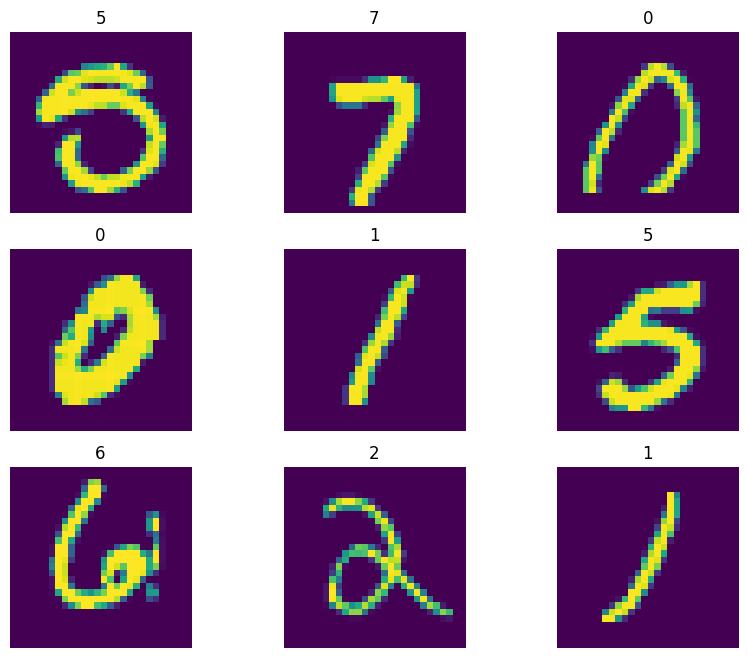

In [4]:
# plot di alcune delle immagini

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #imshow si aspetta shape (h,w,channels)
plt.show()

In [23]:
class MLP_Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # Per valori in [-1,1]
        )

    def forward(self, z):
        return self.model(z)

In [25]:
class MLP_Discriminator(nn.Module):
    def __init__(self, output_dim):
        super(MLP_Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(output_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output tra 0 e 1
        )

    def forward(self, x):
        return self.model(x)

In [26]:


noise_dim = 60
output_dim = 28 * 28
generator = MLP_Generator(noise_dim,output_dim)
discriminator = MLP_Discriminator(output_dim)

loss_func = nn.BCELoss()  # Binary Cross Entropy Loss
opt_G = optim.Adam(generator.parameters(), lr=0.0002)
opt_D = optim.Adam(discriminator.parameters(), lr=0.0002)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sposta i modelli sulla GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)



In [28]:
num_epochs = 20

for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)  # Sposta le immagini sulla GPU
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Allenamento Discriminatore
        real_outputs = discriminator(real_images)
        d_loss_real = loss_func(real_outputs, real_labels)

        z = torch.randn(batch_size, 100).to(device)  # Genera rumore sulla GPU
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())  # No backprop per il generatore
        d_loss_fake = loss_func(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # Allenamento Generatore
        fake_outputs = discriminator(fake_images)
        g_loss = loss_func(fake_outputs, real_labels)  # Il generatore cerca di ingannare il discriminatore

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')



Epoch [1/20], D Loss: 1.3968, G Loss: 0.6703
Epoch [2/20], D Loss: 1.3935, G Loss: 0.6704
Epoch [3/20], D Loss: 1.4018, G Loss: 0.6700
Epoch [4/20], D Loss: 1.4033, G Loss: 0.6701
Epoch [5/20], D Loss: 1.4040, G Loss: 0.6698
Epoch [6/20], D Loss: 1.4052, G Loss: 0.6698
Epoch [7/20], D Loss: 1.4034, G Loss: 0.6703
Epoch [8/20], D Loss: 1.4038, G Loss: 0.6700
Epoch [9/20], D Loss: 1.4016, G Loss: 0.6700
Epoch [10/20], D Loss: 1.3991, G Loss: 0.6701
Epoch [11/20], D Loss: 1.4084, G Loss: 0.6700
Epoch [12/20], D Loss: 1.4034, G Loss: 0.6702
Epoch [13/20], D Loss: 1.4045, G Loss: 0.6698
Epoch [14/20], D Loss: 1.3971, G Loss: 0.6702
Epoch [15/20], D Loss: 1.4012, G Loss: 0.6702
Epoch [16/20], D Loss: 1.4000, G Loss: 0.6697
Epoch [17/20], D Loss: 1.4026, G Loss: 0.6700
Epoch [18/20], D Loss: 1.4025, G Loss: 0.6702
Epoch [19/20], D Loss: 1.3993, G Loss: 0.6700
Epoch [20/20], D Loss: 1.4010, G Loss: 0.6700


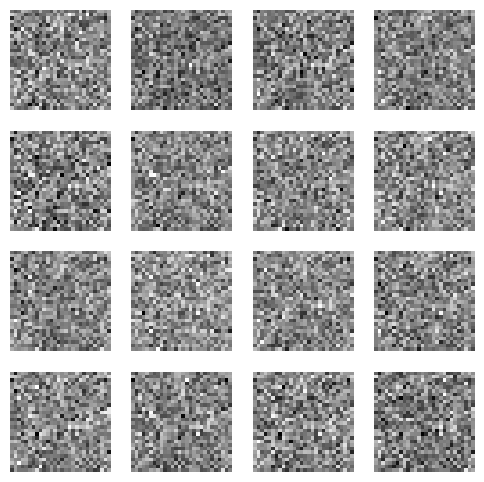

In [21]:
z = torch.randn(16, 100)  # 16 immagini casuali
generator.to('cpu')  # Sposta il generatore su CPU
generated_images = generator(z).detach().numpy()

fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[i*4 + j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')
plt.show()
